# Imports

In [805]:
# Basics
import numpy as np
import pandas as pd

# SMOTE to fix class imbalance
from imblearn.over_sampling import SMOTE

# For missing data imputation
from fancyimpute import MICE

# General sklearn imports
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score

# sklearn model imports
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC

# Neural Network imports
from keras.models import Sequential
from keras.layers import Dense, Dropout

# Plotting imports
import matplotlib.pyplot as plt
%matplotlib inline

# Formatting
colors = {
    'dark': '#1A2533',
    'gray': '#CCCCCC',
    'blue': '#67CDFF',
    'green': '#19EE9A',
    'yellow': '#F7FF48',
    'orange': '#FFB115',
    'pink': '#FF1D97',
    'purple': '#8F6AFF'
}

# Functions

In [806]:
def find_optimal_incentive(row):
    '''
    Apply function to search the defined linear space for 
    optimal value of function defined below.
    '''
    base_prob = row['base_renewal_prob']
    premium = row['premium']
    incentives = np.linspace(start=0, stop=1600, num=160000)
    
    profit = ((base_prob + 0.2*(1-np.exp(-(10*(1-np.exp(-incentives/400)))/5)))*premium) \
              - incentives
        
    max_profit = max(profit)
    opt_incentive = incentives[profit.argmax()]
    
    return opt_incentive

In [820]:
def find_profit(row):
    '''
    Apply function to search the defined linear space for 
    the profit of function defined below.
    '''
    base_prob = row['base_renewal_prob']
    premium = row['premium']
    incentives = np.linspace(start=0, stop=1600, num=160000)
    
    profit = ((base_prob + 0.2*(1-np.exp(-(10*(1-np.exp(-incentives/400)))/5)))*premium) \
              - incentives
        
    max_profit = max(profit)
    
    return max_profit

In [807]:
def check_all_cash(row):
    '''
    Apply function to one hot encode those who have paid fully
    in fully in cash
    '''
    if row['perc_premium_paid_by_cash_credit'] == 0.0:
        return 1
    else: 
        return 0

In [808]:
def check_all_credit(row):
    '''
    Apply function to one hot encode those who have paid fully
    in fully in credit
    '''
    if row['perc_premium_paid_by_cash_credit'] == 1.0:
        return 1
    else: 
        return 0

In [809]:
def check_high_premium(row):
    '''
    Apply function to sort customers who have high premiums
    into their own group of high premium holders
    '''
    if row['premium'] > 30000:
        return 1
    else:
        return 0

In [810]:
def optimize_cart_model(model, parameters, optimization_type):
    
    if optimization_type == 'grid':
        opt = GridSearchCV(estimator=model, param_grid=parameters)
        
    elif optimization_type == 'random':
        opt = RandomizedSearchCV(estimator=model, param_distributions=parameters)
        
    else:
        print('Please select either grid or random optimization type')
        pass
    
    opt.fit(X_synth, y_synth)
    
    print(f'Results of {optimization_type} search')
    print(f'best training score is: {opt.best_score_}')
    print(f'best validation score is: {opt.score(X_val, y_val)}')
    print(f'corresponding AUROC score: {roc_auc_score(y_val, opt.predict(X_val))}')
    print(f'best parameters are: {opt.best_params_}')
    
    return model

# Load Data

In [709]:
# Load data and drop the id row
train = pd.read_csv('./data/train.csv')
train.drop(['id'], axis=1, inplace=True)
test = pd.read_csv('./data/test.csv')
test_ids = test['id'].copy() # Copying to concat on submission at end
test.drop(['id'], axis=1, inplace=True)

# Exploratory Data Analysis

In [710]:
print('train shape:', train.shape)
print('test shape:', test.shape)

train shape: (79853, 12)
test shape: (34224, 11)


In [722]:
train.head()

,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,premium,renewal,sourcing_channel_A,sourcing_channel_B,sourcing_channel_C,sourcing_channel_D,sourcing_channel_E,residence_area_type_Rural,residence_area_type_Urban
0,0.429,12058.0,355060.0,0.0,0.0,0.0,99.02,13.0,3300.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.010,21546.0,315150.0,0.0,0.0,0.0,99.89,21.0,18000.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.917,17531.0,84140.0,2.0,3.0,1.0,98.69,7.0,3300.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.049,15341.0,250510.0,0.0,0.0,0.0,99.57,9.0,9600.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.052,31400.0,198680.0,0.0,0.0,0.0,99.87,12.0,9600.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [723]:
test.head()

,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,premium,sourcing_channel_A,sourcing_channel_B,sourcing_channel_C,sourcing_channel_D,sourcing_channel_E,residence_area_type_Rural,residence_area_type_Urban
0,0.001,27384.0,51150.0,0.0,0.0,0.0,99.890000,7.0,3300.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.124,23735.0,285140.0,0.0,0.0,0.0,98.930000,19.0,11700.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.000,17170.0,186030.0,0.0,0.0,0.0,99.005774,2.0,11700.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.198,16068.0,123540.0,0.0,0.0,0.0,99.000000,11.0,5400.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.041,10591.0,200020.0,1.0,0.0,0.0,99.170000,14.0,9600.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [713]:
train['sourcing_channel'].unique()

array(['C', 'A', 'B', 'D', 'E'], dtype=object)

In [714]:
train['residence_area_type'].unique()

array(['Urban', 'Rural'], dtype=object)

In [715]:
train.describe()

,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,premium,renewal
count,79853.000000,79853.000000,7.985300e+04,79756.000000,79756.000000,79756.000000,76879.000000,79853.000000,79853.000000,79853.000000
mean,0.314288,18846.696906,2.088472e+05,0.248671,0.078188,0.060008,99.067291,10.863887,10924.507533,0.937410
std,0.334915,5208.719136,4.965826e+05,0.691468,0.436507,0.312023,0.739799,5.170687,9401.676542,0.242226
min,0.000000,7670.000000,2.403000e+04,0.000000,0.000000,0.000000,91.900000,2.000000,1200.000000,0.000000
25%,0.034000,14974.000000,1.080100e+05,0.000000,0.000000,0.000000,98.810000,7.000000,5400.000000,1.000000
50%,0.167000,18625.000000,1.665600e+05,0.000000,0.000000,0.000000,99.210000,10.000000,7500.000000,1.000000
75%,0.538000,22636.000000,2.520900e+05,0.000000,0.000000,0.000000,99.540000,14.000000,13800.000000,1.000000
max,1.000000,37602.000000,9.026260e+07,13.000000,17.000000,11.000000,99.890000,60.000000,60000.000000,1.000000


In [716]:
# Train is missing values in 3-6 mo late, 6-12 mo late, over 12 mo late, and underwriting score
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79853 entries, 0 to 79852
Data columns (total 12 columns):
perc_premium_paid_by_cash_credit    79853 non-null float64
age_in_days                         79853 non-null int64
Income                              79853 non-null int64
Count_3-6_months_late               79756 non-null float64
Count_6-12_months_late              79756 non-null float64
Count_more_than_12_months_late      79756 non-null float64
application_underwriting_score      76879 non-null float64
no_of_premiums_paid                 79853 non-null int64
sourcing_channel                    79853 non-null object
residence_area_type                 79853 non-null object
premium                             79853 non-null int64
renewal                             79853 non-null int64
dtypes: float64(5), int64(5), object(2)
memory usage: 7.3+ MB


In [717]:
train.columns

Index(['perc_premium_paid_by_cash_credit', 'age_in_days', 'Income',
       'Count_3-6_months_late', 'Count_6-12_months_late',
       'Count_more_than_12_months_late', 'application_underwriting_score',
       'no_of_premiums_paid', 'sourcing_channel', 'residence_area_type',
       'premium', 'renewal'],
      dtype='object')

### Feature Histograms

1.0    74855
0.0     4998
Name: renewal, dtype: int64

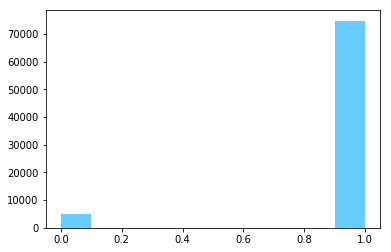

In [162]:
plt.hist(train['renewal'], color=colors['blue']);
train['renewal'].value_counts()

Above shows imbalanced classes, should oversample from non-renewals

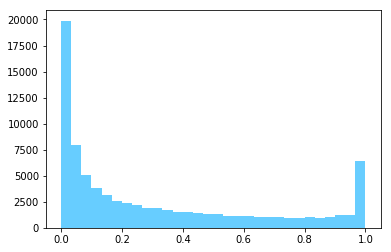

In [288]:
plt.hist(train['perc_premium_paid_by_cash_credit'], bins=30, color=colors['blue']);

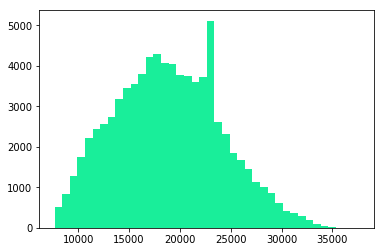

In [215]:
plt.hist(train['age_in_days'], bins=40, color=colors['green']);

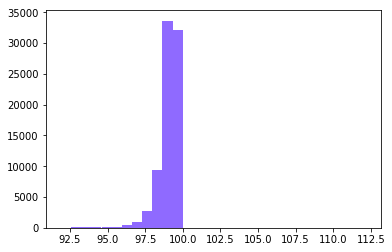

In [294]:
plt.hist(train['application_underwriting_score'], bins=30, color=colors['purple']);

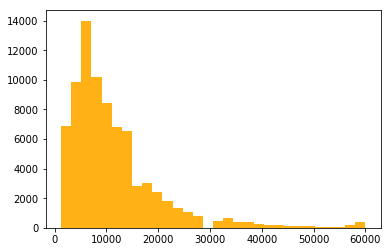

In [300]:
counts, bins, bars = plt.hist(train['premium'], bins=30, color=colors['orange']);

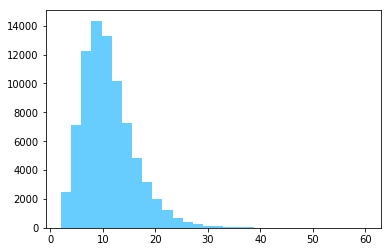

In [149]:
plt.hist(train['no_of_premiums_paid'], bins=30, color=colors['blue']);

# Feature Engineering

#### Encode all features

In [718]:
# One hot encoded the sourcing_channel and residence_area_type features
train = pd.concat([train, pd.get_dummies(train['sourcing_channel'], prefix='sourcing_channel')], axis=1)
train = pd.concat([train, pd.get_dummies(train['residence_area_type'], prefix='residence_area_type')], axis=1)
train.drop(['sourcing_channel', 'residence_area_type'], axis=1, inplace=True)

In [719]:
# One hot encode the same features for the test data
test = pd.concat([test, pd.get_dummies(test['sourcing_channel'], prefix='sourcing_channel')], axis=1)
test = pd.concat([test, pd.get_dummies(test['residence_area_type'], prefix='residence_area_type')], axis=1)
test.drop(['sourcing_channel', 'residence_area_type'], axis=1, inplace=True)

#### Impute missing records

In [720]:
mice_train = MICE(verbose=False)
train = pd.DataFrame(data=mice_train.complete(train), columns=train.columns, index=train.index)
train.isnull().sum().sum()
# Should return 0

0

In [721]:
mice_test = MICE(verbose=False)
test = pd.DataFrame(data=mice_test.complete(test), columns=test.columns, index=test.index)
test.isnull().sum().sum()
# Should return 0

0

#### Create incentive dataframe to use later for modeling

In [724]:
inc = pd.DataFrame(test['premium'].copy())

#### Custom Features

In [725]:
#Boolean feature for people who pay all cash
train['all_cash'] = train.apply(check_all_cash, axis=1)
test['all_cash'] = test.apply(check_all_cash, axis=1)

In [726]:
# Boolean feature for people who pay all credit
train['all_credit'] = train.apply(check_all_credit, axis=1)
test['all_credit'] = test.apply(check_all_credit, axis=1)

In [727]:
# Boolean feature for those with high premiums
train['high_premium'] = train.apply(check_high_premium, axis=1)
test['high_premium'] = test.apply(check_high_premium, axis=1)

### Scale all data

In [728]:
# Set aside target data as y, which later be train/validation split
y = train['renewal'].copy()
train.drop(['renewal'], axis=1, inplace=True)

In [729]:
# Save the max index of train data to retrieve it after scaling
train_max_index = train.shape[0]
print(train.shape[0])
print(test.shape[0])

# Combine train and test data sets for scaling
full = pd.concat([train, test], axis=0, ignore_index=True)

# Scale X_train and X_val
full = StandardScaler().fit_transform(full)

# Set to DataFrame
full = pd.DataFrame(full, columns=train.columns)

79853
34224


In [730]:
train = full[full.index < train_max_index].copy()
test = full[full.index >= train_max_index].copy()
print(train.shape[0])
print(test.shape[0])

79853
34224


### Setup X and y

In [731]:
# Instantiate X
X = train.copy()

# train/validate split X and y
X_train, X_val, y_train, y_val = train_test_split(X, y)

# Oversample non-renewals with SMOTE
sm = SMOTE(random_state=15)
X_synth, y_synth = sm.fit_sample(X_train, y_train)
print(f'y_synth counts of positive class: {format(sum(y_synth==1))}')
print(f'y_synth counts of negative class: {format(sum(y_synth==0))}')

y_synth counts of positive class: 56168
y_synth counts of negative class: 56168


In [732]:
len(y_synth)

112336

In [733]:
X_train.columns

Index(['perc_premium_paid_by_cash_credit', 'age_in_days', 'Income',
       'Count_3-6_months_late', 'Count_6-12_months_late',
       'Count_more_than_12_months_late', 'application_underwriting_score',
       'no_of_premiums_paid', 'premium', 'sourcing_channel_A',
       'sourcing_channel_B', 'sourcing_channel_C', 'sourcing_channel_D',
       'sourcing_channel_E', 'residence_area_type_Rural',
       'residence_area_type_Urban', 'all_cash', 'all_credit', 'high_premium'],
      dtype='object')

In [734]:
y_train.shape

(59889,)

In [735]:
X_val.columns

Index(['perc_premium_paid_by_cash_credit', 'age_in_days', 'Income',
       'Count_3-6_months_late', 'Count_6-12_months_late',
       'Count_more_than_12_months_late', 'application_underwriting_score',
       'no_of_premiums_paid', 'premium', 'sourcing_channel_A',
       'sourcing_channel_B', 'sourcing_channel_C', 'sourcing_channel_D',
       'sourcing_channel_E', 'residence_area_type_Rural',
       'residence_area_type_Urban', 'all_cash', 'all_credit', 'high_premium'],
      dtype='object')

In [736]:
y_val.shape

(19964,)

# Renewal Modeling
Find the best classifier for predicting if an insurance patron will renew their policy

#### Logistic Regression

In [737]:
lr = LogisticRegression()
lr.fit(X_synth, y_synth)
print(lr.score(X_synth, y_synth))
print(lr.score(X_val, y_val))
print(roc_auc_score(y_val, lr.predict(X_val)))

0.7550206523287281
0.7792526547786015
0.7573269521535978


#### Gradient Boosted Classifier
First is random search to narrow down hyperparameters, then gridsearch is performed around the random search results to further tune. This process is the same for gradient boost and random forest models 

In [84]:
# # Estimator model 
# gbc = GradientBoostingClassifier()

# # parameters for randomsearch
# gbc_rand_params = {
#     'learning_rate': np.linspace(0.0001, 1.0, 100),
#     'n_estimators': np.arange(5, 100, 1),
#     'max_depth': [2, 3, 4, 5, 6],
#     'min_samples_split': [2, 3, 4],
#     'min_samples_leaf': [1, 2, 3]
# }

# # perform randomsearch on gbc
# optimize_cart_model(gbc, gbc_rand_params, 'random')

In [85]:
# # parameters for gridsearch
# gbc_grid_params = {
#     'n_estimators': [80, 81],
#     'min_samples_split': [2, 3],
#     'min_samples_leaf': [3, 4],
#     'max_depth': [6, 7],
#     'learning_rate': [0.25, 0.3]
# }

# # performn gridsearch on gbc
# optimize_cart_model(gbc, gbc_grid_params, 'grid')

#### Random Forest Classifier

In [86]:
# # Estimator model
# rfc = RandomForestClassifier()

# # rfc randomsearch parameters
# rfc_rand_params = {
#     'n_estimators': np.arange(5, 100, 1),
#     'max_depth': [None, 2, 3, 4, 5],
#     'min_samples_split': [2, 3, 4],
#     'min_samples_leaf': [1, 2, 3]
# }

# # randomsearch rfc parameters
# optimize_cart_model(rfc, rfc_rand_params, 'random')

In [87]:
# # rfc gridsearch parameters
# rfc_grid_params = {
#     'n_estimators': [78, 79, 80],
#     'max_depth': [None, 2],
#     'min_samples_split': [3, 4, 5],
#     'min_samples_leaf': [2, 3, 4]
# }

# # optimize rfc parameters with gridsearch
# optimize_cart_model(rfc, rfc_grid_params, 'grid')

#### Neural Network

0.7656226199068284


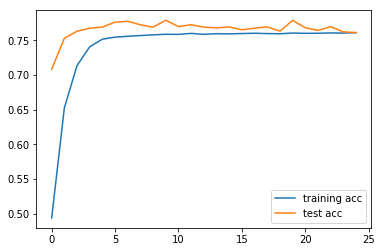

In [738]:
nn = Sequential()
nn.add(Dense(20, activation='tanh', input_dim=X_train.shape[1]))
nn.add(Dropout(0.4))
nn.add(Dense(1))

nn.compile(optimizer='adam',loss='mean_squared_error', metrics=['acc'])

nn_output = nn.fit(X_synth, y_synth, 
                   validation_data=(X_val, y_val), 
                   epochs=25, 
                   batch_size=400, 
                   verbose=0)

print(roc_auc_score(y_val, nn.predict_classes(X_val)));

nn_train_acc = nn_output.history['acc']
nn_test_acc = nn_output.history['val_acc']
plt.plot(nn_train_acc, label='training acc')
plt.plot(nn_test_acc, label='test acc')
plt.legend();

# Incentives Modeling

Uses the earlier copied 'inc' dataframe

In [739]:
inc['base_renewal_prob'] = nn.predict(test)

In [812]:
# Finds the optimal incentive per each policy
inc['incentive'] = inc.apply(find_optimal_incentive, axis=1)

In [821]:
# Finds the profit per each policy
inc['profit'] = inc.apply(find_profit, axis=1)

In [822]:
inc.shape

(34224, 4)

In [823]:
inc.head()

,premium,base_renewal_prob,incentive,profit
0,3300.0,0.909137,183.381146,3160.447785
1,11700.0,0.791037,446.102788,10538.965796
2,11700.0,0.488536,446.102788,6999.698599
3,5400.0,0.730247,275.911724,4348.768175
4,9600.0,0.529880,399.432496,6064.540603


#### Plots for incentives modeling

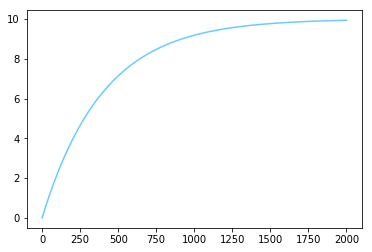

In [815]:
# Range for incentives, realistically tops out at 1600
incentive_range = np.linspace(start=0, stop=2000, num=10000)

# Plot the extra effort from increasing incentives
effort = 10*(1-np.exp(-incentive_range/400))
plt.plot(incentive_range, effort, color=colors['blue']);

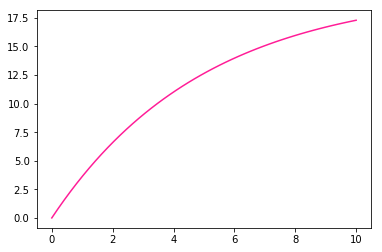

In [816]:
# Range of effort, tops out at 10 extra hours
effort_range = np.linspace(start=0, stop = 10)

# Plot the increased renewal probability per extra effort
delta_prob = 20*(1-np.exp(-effort_range/5))
plt.plot(effort_range, delta_prob, color=colors['pink']);

maximum policy profit: 6999.698592331408
corresponding optimal incentive: 446.044604460446


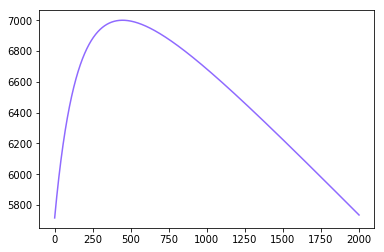

In [818]:
# Policy index number to check
policy = 2

# Plot the curve of profit over incentive
revenue = (inc['base_renewal_prob'][policy] + \
           0.2*(1-np.exp(-(10*(1-np.exp(-incentive_range/400)))/5))) \
           *(inc['premium'][policy]) - incentive_range
plt.plot(incentive_range, revenue, color=colors['purple']);

# Find and print the max values of interest
max_revenue = max(revenue)
opt_incentive = incentive_range[revenue.argmax()]
print('maximum policy profit:', max_revenue)
print('corresponding optimal incentive:', opt_incentive)

In [832]:
# # Plot scatter of all policies incentive vs. profit
# plt.figure(figsize=(10,6))
# plt.scatter(x=inc['incentive'], y=inc['profit'], color=colors['green'], alpha=0.2);

# Output

In [761]:
sub = pd.DataFrame(test_ids)

In [762]:
sub.shape

(34224, 1)

In [763]:
test.shape

(34224, 19)

In [764]:
X_test = test

ss = StandardScaler()
X_test = ss.fit_transform(X_test)

In [765]:
sub['renewal'] = nn.predict_classes(X_test)

In [766]:
sub['incentives'] = inc['incentive']

In [767]:
sub.head()

,id,renewal,incentives
0,649,1,183.377834
1,81136,1,446.100461
2,70762,0,446.100461
3,53935,1,275.906759
4,15476,1,399.427994


#### Writeout submission csv

In [105]:
# file = './VERSION.csv'
# sub.to_csv(file, index=False)